In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import model_functions
from sklearn.inspection import partial_dependence,plot_partial_dependence
from lime.lime_tabular import LimeTabularExplainer
import lime
import lime.lime_tabular

In [2]:
import sklearn
print(sklearn.__version__)

0.24.1


In [3]:
df = pd.read_csv("data/df_prep_2.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'cosine_similarity', 'first_word', 'second_word',
       'correlation_of_context', 'first_second', 'frequency_co_occurrence',
       'frequency_w1', 'frequency_w2', 'df_word1', 'no_words_corpus',
       'tf_rel_word1', 'tf_rel_word2', 'word1_length', 'word2_length',
       'syn_match', 'syn_match_perc', 'syn1_count', 'syn2_count', 'ant_match',
       'ant_match_perc', 'ant1_count', 'ant2_count', 'word1_pos_tags',
       'word2_pos_tags', 'is_stop_word1', 'is_stop_word2', 'pos_tag_eq'],
      dtype='object')

In [5]:
df["similarity_category"] = np.where(df["cosine_similarity"]>=0.5, 1, 0)

In [6]:
df["fraq_first_second"] = df["frequency_w1"] / df["frequency_w2"]
df["freq_co_occ_mult_fraq_first_second"] = df["frequency_co_occurrence"] * df["fraq_first_second"]
df["fraq_syn1_syn2"] = df["syn1_count"]/df["syn2_count"]
df["syn_match_mult_fraq_syn"] = df["syn_match"]* df["fraq_syn1_syn2"]
df["is_stop_word_eq"] = (df["is_stop_word1"]==df["is_stop_word2"]).astype(int)

In [7]:
one_hot_encoded = pd.get_dummies(df['word1_pos_tags'], prefix='word1_pos_tag_')
df = pd.concat([df, one_hot_encoded], axis=1)

one_hot_encoded2 = pd.get_dummies(df['word2_pos_tags'], prefix='word2_pos_tag_')
df = pd.concat([df, one_hot_encoded2], axis=1)

In [8]:
df.replace(np.nan, 0, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.replace(np.nan, 100, inplace=True)

In [9]:
df = df.set_index("first_second")

In [10]:
df.sort_values("cosine_similarity",ascending=False)

Unnamed: 0  cosine_similarity first_word second_word  \
first_second                                                              
okay_ok                292089           0.981483       okay          ok   
husband_wife            85894           0.974152    husband        wife   
server_waiter         1199674           0.973378     server      waiter   
terrible_horrible     2159024           0.970990   terrible    horrible   
server_waitress       1198836           0.963580     server    waitress   
...                       ...                ...        ...         ...   
creme_students        2344248          -0.131493      creme    students   
cooked_com             305537          -0.133579     cooked         com   
perfectly_com          921662          -0.142126  perfectly         com   
bone_com              2036132          -0.148426       bone         com   
balanced_com          2486357          -0.165899   balanced         com   

                   correlation_of_context  frequency_co_occurrence  \
first_second                                                         
okay_ok                          0.997535                        4   
husband_wife                     0.994511                       80   
server_waiter                    0.975994                       11   
terrible_horrible                0.992902                       13   
server_waitress                  0.967092                       18   
...                                   ...                      ...   
creme_students                   0.582018                        0   
cooked_com                       0.328019                        0   
perfectly_com                    0.313331                        0   
bone_com                         0.319751                        0   
balanced_com                     0.299983                        0   

                   frequency_w1  frequency_w2  df_word1  no_words_corpus  ...  \
first_second                                                              ...   
okay_ok                    5015          9730      5015        109853731  ...   
husband_wife               9241          7210      9241        109853731  ...   
server_waiter             12033          6253     12033        109853731  ...   
terrible_horrible          4172          3756      4172        109853731  ...   
server_waitress           12033          9124     12033        109853731  ...   
...                         ...           ...       ...              ...  ...   
creme_students              615           584       615        109853731  ...   
cooked_com                 8469           769      8469        109853731  ...   
perfectly_com              5373           769      5373        109853731  ...   
bone_com                    967           769       967        109853731  ...   
balanced_com                546           769       546        109853731  ...   

                   word2_pos_tag__['NOUN']  word2_pos_tag__['NUM']  \
first_second                                                         
okay_ok                                  0                       0   
husband_wife                             1                       0   
server_waiter                            1                       0   
terrible_horrible                        0                       0   
server_waitress                          1                       0   
...                                    ...                     ...   
creme_students                           1                       0   
cooked_com                               1                       0   
perfectly_com                            1                       0   
bone_com                                 1                       0   
balanced_com                             1                       0   

                   word2_pos_tag__['PART']  word2_pos_tag__['PRON']  \
first_second                                                          
okay_ok                  

In [11]:
df[df["cosine_similarity"]>0.9].sort_values("correlation_of_context")[:20]

Unnamed: 0  cosine_similarity    first_word  \
first_second                                                            
untorn_adhd                  1932938           0.902589        untorn   
mf_perish                    1315431           0.907261            mf   
interstellar_upack           1066749           0.902357  interstellar   
perish_unassumingly          1782383           0.914131        perish   
interstellar_laney           1067242           0.900544  interstellar   
uf_mf                          56295           0.906909            uf   
footsteps_roomskeeper        1282491           0.906261     footsteps   
refreshers_laney             1751982           0.909164    refreshers   
excelsior_perish             1640673           0.901010     excelsior   
bano_glowingly                365570           0.900747          bano   
shortages_perish              852165           0.904988     shortages   
jeremiah_laney               1922404           0.901747      jeremiah   
cream_ice                     146631           0.900866         cream   
browns_hash                   978387           0.908376        browns   
parsnips_enoki                600810           0.918520      parsnips   
sprouts_brussel              2013433           0.916244       sprouts   
reservations_reservation       32190           0.900971  reservations   
husband_hubby                  85685           0.932386       husband   
boyfriend_hubby              1725505           0.931514     boyfriend   
hubby_wife                   2170075           0.914253         hubby   

                           second_word  correlation_of_context  \
first_second                                                     
untorn_adhd                       adhd               -0.000127   
mf_perish                       perish               -0.000122   
interstellar_upack               upack                0.055939   
perish_unassumingly       unassumingly                0.096120   
interstellar_laney               laney                0.096120   
uf_mf                               mf                0.099916   
footsteps_roomskeeper      roomskeeper                0.118984   
refreshers_laney                 laney                0.135938   
excelsior_perish                perish                0.136011   
bano_glowingly               glowingly                0.154974   
shortages_perish                perish                0.264815   
jeremiah_laney                   laney                0.271984   
cream_ice                          ice                0.420699   
browns_hash                       hash                0.490280   
parsnips_enoki                   enoki                0.522752   
sprouts_brussel                brussel                0.542971   
reservations_reservation   reservation                0.738430   
husband_hubby                    hubby                0.856843   
boyfriend_hubby                  hubby                0.861164   
hubby_wife                        wife                0.896980   

                          frequency_co_occurrence  frequency_w1  frequency_w2  \
first_second                                                                    
untorn_adhd                                     0             1             4   
mf_perish                                       0             4             1   
interstellar_upack                              0             1             7   
perish_unassumingly                             0             1             3   
interstellar_laney                              0             1             3   
uf_mf                                           0             6             4   
footsteps_roomskeeper                           0             6             1   
refreshers_laney                                0             2             3   
excelsior_perish                                0             2             1   
bano_glowingly                                  0             3            

array([[<AxesSubplot:title={'center':'frequency_co_occurrence'}>]],
      dtype=object)

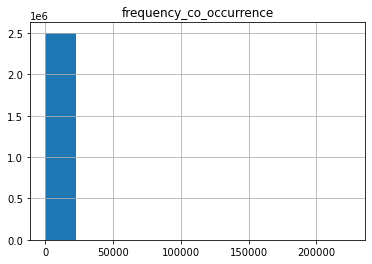

In [12]:
df[["frequency_co_occurrence"]].hist()

In [13]:
avg = df["frequency_co_occurrence"].mean()
s = df["frequency_co_occurrence"].std()
df["frequency_co_occurrence"] = (df["frequency_co_occurrence"]-avg)/s

array([[<AxesSubplot:title={'center':'frequency_co_occurrence'}>]],
      dtype=object)

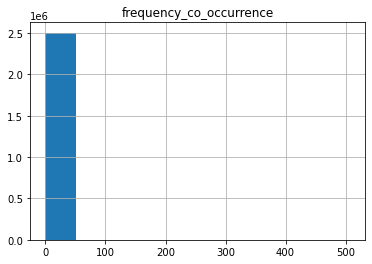

In [14]:
df[["frequency_co_occurrence"]].hist()

In [15]:
df

Unnamed: 0  cosine_similarity first_word second_word  \
first_second                                                             
type_when                  0           0.300317       type        when   
type_would                 1           0.395349       type       would   
type_followed              2           0.253379       type    followed   
type_she                   3           0.204571       type         she   
type_always                4           0.265206       type      always   
...                      ...                ...        ...         ...   
recipe_saki          2503198           0.421382     recipe        saki   
recipe_intimate      2503199           0.238683     recipe    intimate   
clayton_saki         2503200           0.318745    clayton        saki   
clayton_intimate     2503201           0.334505    clayton    intimate   
saki_intimate        2503202           0.262342       saki    intimate   

                  correlation_of_context  frequency_co_occurrence  \
first_second                                                        
type_when                       0.512748                -0.001927   
type_would                      0.440563                 0.011616   
type_followed                   0.503107                -0.040299   
type_she                        0.511910                 0.009358   
type_always                     0.541555                -0.019984   
...                                  ...                      ...   
recipe_saki                     0.738245                -0.040299   
recipe_intimate                 0.685028                -0.040299   
clayton_saki                    0.666173                -0.040299   
clayton_intimate                0.597443                -0.040299   
saki_intimate                   0.728672                -0.040299   

                  frequency_w1  frequency_w2  df_word1  no_words_corpus  ...  \
first_second                                                             ...   
type_when                 3401         53246      3401        109853731  ...   
type_would                3401         53755      3401        109853731  ...   
type_followed             3401           815      3401        109853731  ...   
type_she                  3401         39663      3401        109853731  ...   
type_always               3401         29915      3401        109853731  ...   
...                        ...           ...       ...              ...  ...   
recipe_saki                495            95       495        109853731  ...   
recipe_intimate            495           895       495        109853731  ...   
clayton_saki               216            95       216        109853731  ...   
clayton_intimate           216           895       216        109853731  ...   
saki_intimate               95           895        95        109853731  ...   

                  word2_pos_tag__['NOUN']  word2_pos_tag__['NUM']  \
first_second                                                        
type_when                               0                       0   
type_would                              0                       0   
type_followed                           0                       0   
type_she                                0                       0   
type_always                             0                       0   
...                                   ...                     ...   
recipe_saki                             0                       0   
recipe_intimate                         0                       0   
clayton_saki                            0                       0   
clayton_intimate                        0                       0   
saki_intimate                           0                       0   

                  word2_pos_tag__['PART']  word2_pos_tag__['PRON']  \
first_second                                                         
type_when                               0                        0   
type_wou

In [16]:
X = df[
    ["correlation_of_context","frequency_co_occurrence","syn_match",
        "syn_match_perc","syn1_count","ant_match","ant_match_perc",
        "ant1_count","ant2_count","pos_tag_eq","frequency_w1","frequency_w2","is_stop_word1","is_stop_word2",
       "fraq_first_second","freq_co_occ_mult_fraq_first_second","fraq_syn1_syn2","syn_match_mult_fraq_syn","is_stop_word_eq"
       ]
      ]


X = df[
    ["correlation_of_context","frequency_co_occurrence",
        "syn_match_perc","syn1_count","ant_match","ant_match_perc",
        "ant1_count","ant2_count","pos_tag_eq","frequency_w1","frequency_w2","is_stop_word1","is_stop_word2",
       "fraq_first_second","freq_co_occ_mult_fraq_first_second","fraq_syn1_syn2","syn_match_mult_fraq_syn","is_stop_word_eq"
       ]
      ]

## Classification

In [17]:
y = df['similarity_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [19]:
y_prob = clf.predict_proba(X_test)[:, 1]

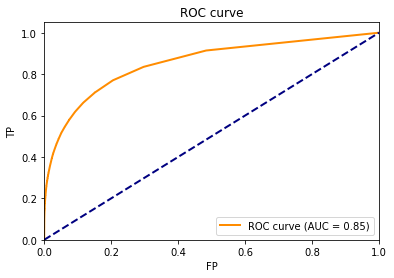

In [20]:
model_functions.roc_plot(y_test,y_prob)

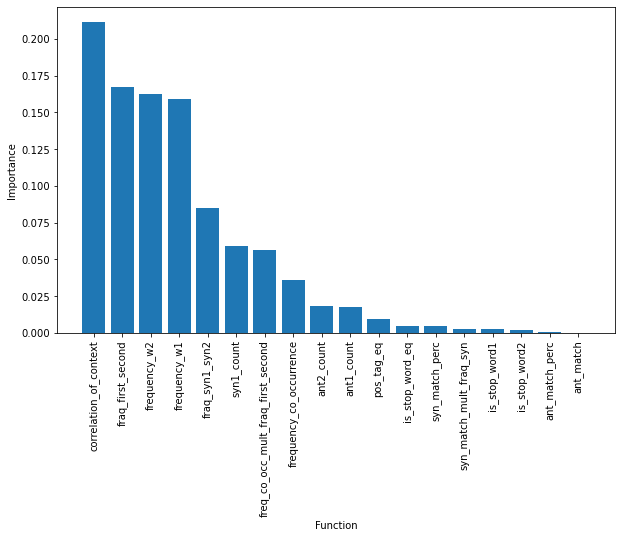

In [21]:
model_functions.fi_plot(clf, X)

In [22]:
def fi_plot(trained_model, X):
    feature_importance = trained_model.feature_importances_
    sorted_indices = feature_importance.argsort()  # odstranění [::-1] pro opačné seřazení
    feature_names = X.columns
    plt.figure(figsize=(6, 10))  # změna velikosti grafu na výšku
    plt.barh(range(len(feature_importance)), feature_importance[sorted_indices], align='center')  # použití barh pro sloupce na výšku
    plt.yticks(range(len(feature_importance)), feature_names[sorted_indices])  # nastavení popisků na osu y
    plt.xlabel('Importance')  # změna popisku osy x
    plt.show()

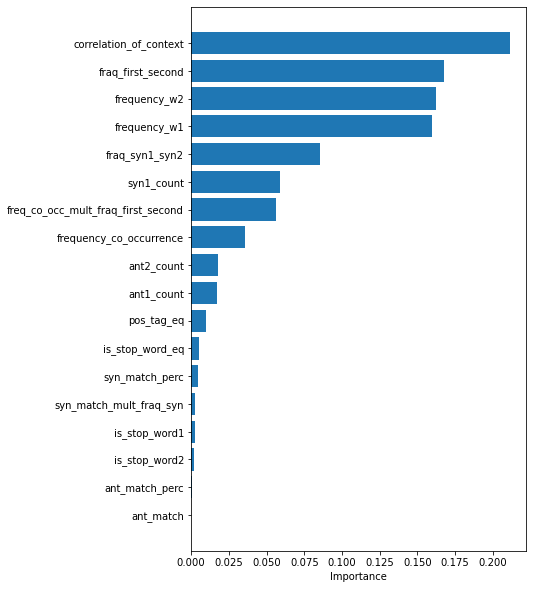

In [23]:
fi_plot(clf, X)

In [24]:
df_pred = pd.DataFrame(y_test)
df_pred["y_prob"] = y_prob
df_pred_f = df_pred.join(df[ (df["cosine_similarity"]>=0.6) | (df["cosine_similarity"]<=0.4) ][["cosine_similarity"]], how = "inner")
y_prob_r = df_pred_f["y_prob"]
y_test_r = df_pred_f["similarity_category"]

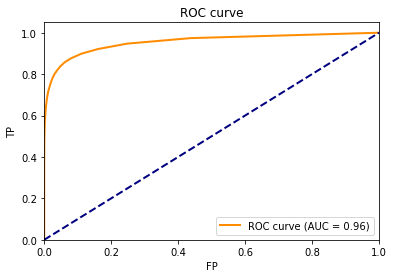

In [25]:
model_functions.roc_plot(y_test_r,y_prob_r)

In [26]:
df_pred = pd.DataFrame(y_test)
df_pred["y_prob"] = y_prob
df_pred = df_pred[ (df_pred["y_prob"]>=0.5) | (df["cosine_similarity"]<=0.5)]
df_pred_f = df_pred.join(df[["cosine_similarity"]], how = "inner")
y_prob_r = df_pred_f["y_prob"]
y_test_r = df_pred_f["similarity_category"]

C:\Users\berl03\AppData\Local\Temp/ipykernel_16584/2437216227.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pred = df_pred[ (df_pred["y_prob"]>=0.5) | (df["cosine_similarity"]<=0.5)]


In [27]:
df_pred_f

similarity_category  y_prob  cosine_similarity
first_second                                                     
families_beyonce                     0    0.04           0.436404
large_inner                          0    0.06           0.233555
those_brow                           0    0.00           0.302152
adds_constantly                      0    0.00           0.127076
the_expensive                        0    0.02           0.382483
...                                ...     ...                ...
medium_inflating                     0    0.10           0.370365
places_shower                        0    0.00           0.126620
unoccupied_adding                    0    0.20           0.312336
only_dorado                          0    0.00           0.312294
also_green                           0    0.02           0.486996

[482318 rows x 3 columns]

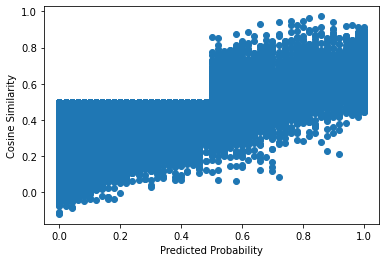

In [28]:
df_pred_f = df_pred.join(df[["cosine_similarity"]], how = "inner")

plt.scatter(df_pred_f["y_prob"], df_pred_f["cosine_similarity"])
plt.xlabel('Predicted Probability')
plt.ylabel('Cosine Similarity')
plt.show()

## Regression

In [29]:
y = df['cosine_similarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
#from sklearn.ensemble import GradientBoostingRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [31]:
predictions = rf.predict(X_test)

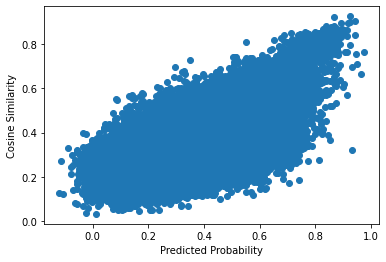

In [32]:
plt.scatter(y_test,predictions)
plt.xlabel('Predicted Probability')
plt.ylabel('Cosine Similarity')
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_val = y_test
y_pred = predictions

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Vytvoření tabulky
eval_metrics = {
    'Mean Absolute Error (MAE)': [mae],
    'Mean Squared Error (MSE)': [mse],
    'Root Mean Squared Error (RMSE)': [rmse],
    'R-squared (R2)': [r2]
}

import pandas as pd
eval_df = pd.DataFrame(eval_metrics)

eval_df = eval_df.T.reset_index()
eval_df.columns = ["Metric","Value"]
eval_df

Metric     Value
0       Mean Absolute Error (MAE)  0.068101
1        Mean Squared Error (MSE)  0.007686
2  Root Mean Squared Error (RMSE)  0.087668
3                  R-squared (R2)  0.324168

In [34]:
corr_df = pd.DataFrame(zip(y_test,predictions),columns = ["y_test","y_pred"])
print(corr_df.corr())

          y_test    y_pred
y_test  1.000000  0.579347
y_pred  0.579347  1.000000


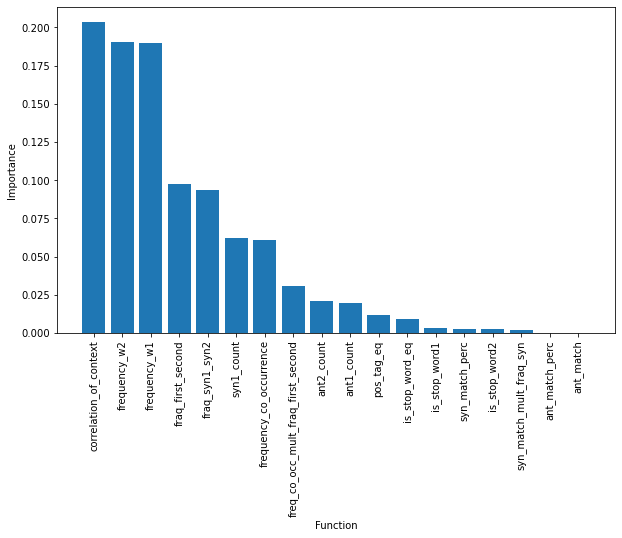

In [35]:
model_functions.fi_plot(rf, X)

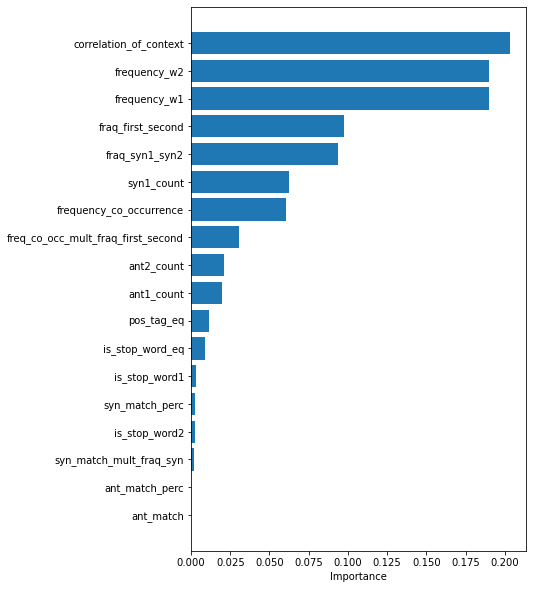

In [36]:
fi_plot(rf, X)

## Partial dependence plots

correlation_of_context
frequency_co_occurrence
syn_match_perc
syn1_count
ant_match
ant_match_perc
ant1_count
ant2_count
pos_tag_eq
frequency_w1


C:\Users\berl03\Anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:732: UserWarning: Attempting to set identical bottom == top == 0.8254830415476571 results in singular transformations; automatically expanding.
  ax.set_ylim(self.pdp_lim[1])


frequency_w2


C:\Users\berl03\Anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:732: UserWarning: Attempting to set identical bottom == top == 0.8254830415476571 results in singular transformations; automatically expanding.
  ax.set_ylim(self.pdp_lim[1])


is_stop_word1
is_stop_word2
fraq_first_second
freq_co_occ_mult_fraq_first_second
fraq_syn1_syn2
syn_match_mult_fraq_syn
is_stop_word_eq


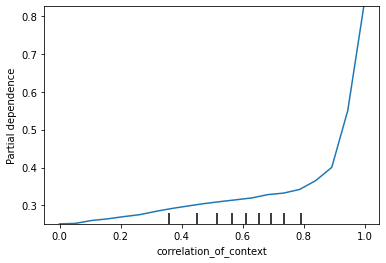

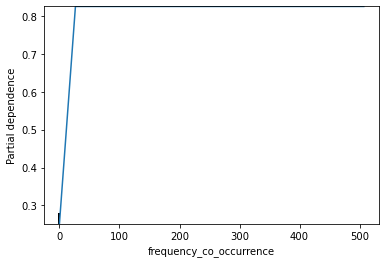

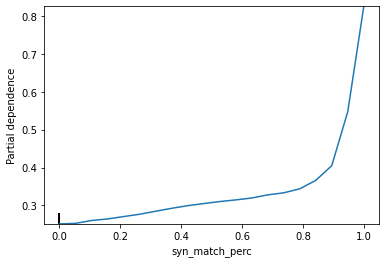

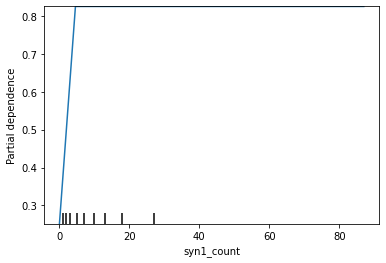

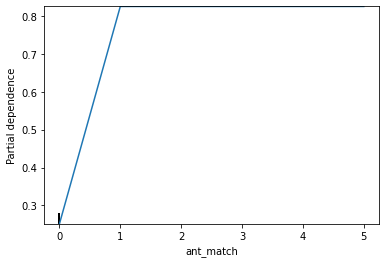

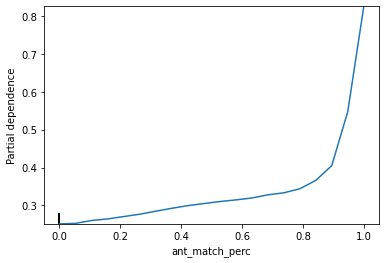

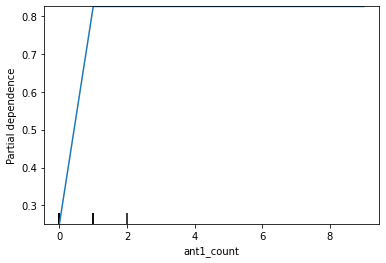

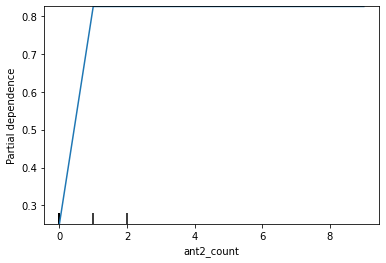

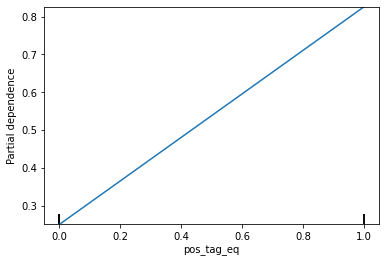

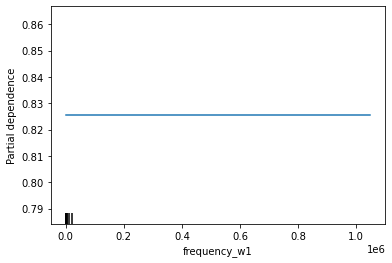

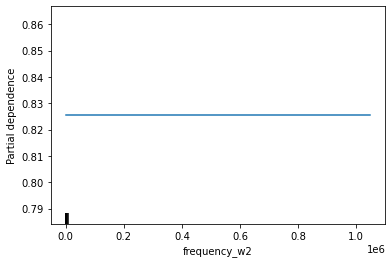

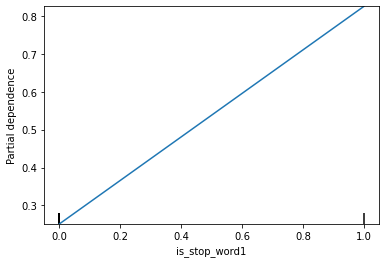

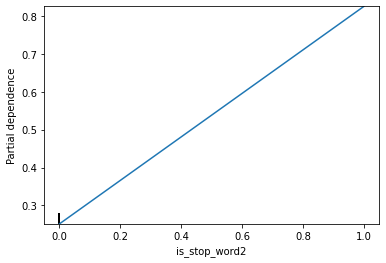

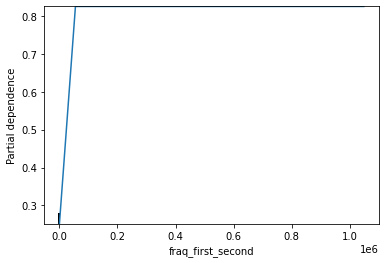

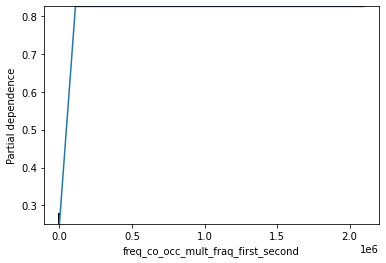

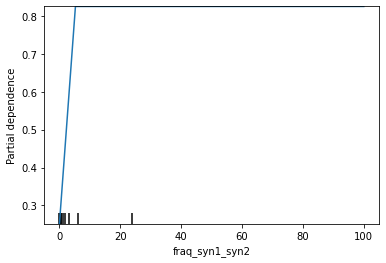

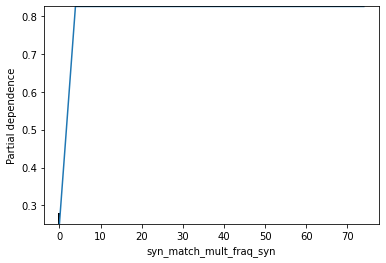

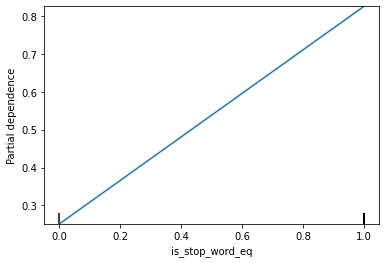

In [37]:
for feature in list(X.columns): 
    print(feature)
    my_plots = plot_partial_dependence(rf,       
                                   features=[0],
                                   X=X[[feature]],            
                                   feature_names=[feature],
                                   n_jobs=1, 
                                   grid_resolution=20, 
                                   percentiles=(0, 1)
                                 ) 

## Local interpretations 

https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-lime

In [38]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns.values.tolist(),
                                                   class_names=['cosine_similarity'], 
                                                   verbose=True, 
                                                   mode='regression')

In [39]:
y_test.reset_index().sort_values("cosine_similarity",ascending=False)[:20]

first_second  cosine_similarity
422569        server_waiter           0.973378
392592      server_waitress           0.963580
37112            three_four           0.948160
293706          minutes_min           0.946710
268032       dining_dinning           0.942533
219997   terrific_fantastic           0.940113
19073       boyfriend_hubby           0.931514
452565            two_three           0.929594
151809      thursday_monday           0.925573
261129     delicious_delish           0.925044
39727            woman_lady           0.924921
169744   favorite_favourite           0.917054
121046  perish_unassumingly           0.914131
189918  sadly_unfortunately           0.913738
21747         monday_friday           0.913581
174515       larger_smaller           0.912132
396652      bland_tasteless           0.905001
329792       crunchy_crispy           0.903487
336260          yummy_tasty           0.900973
55015               bf_wife           0.899784

In [40]:
y_test.reset_index().sort_values("cosine_similarity",ascending=True)[:20]

first_second  cosine_similarity
451715            medium_com          -0.119053
64014         tenderness_com          -0.112583
14798             spiced_com          -0.105807
319272           flavour_via          -0.088258
88376    toyota_accompanying          -0.078962
288528  community_flavorless          -0.075900
355833        print_elephant          -0.075000
413476            subtle_com          -0.070422
385258             al_beauty          -0.069360
66030               dark_com          -0.063610
333884           toyota_airy          -0.062356
155849             strip_com          -0.056395
202713          properly_com          -0.056020
412295       video_satisfied          -0.055546
286982              rich_com          -0.055249
182498           y_corrected          -0.054998
381437          pile_michael          -0.054197
100585              nuts_bus          -0.054183
283766           causes_luke          -0.053940
354050    workers_pronounced          -0.053594

In [41]:
j = 422569
print(X_test.iloc[j].name.split("_"))
exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=6)
exp.show_in_notebook(show_table=True)
print(exp.as_list())

['server', 'waiter']
Intercept 0.43670663531622983
Prediction_local [0.4647396]
Right: 0.766077544


[('frequency_co_occurrence > -0.04', 0.12003775024217053), ('frequency_w1 > 7620.00', -0.1142876120004302), ('frequency_w2 > 2499.00', -0.08194827867899926), ('correlation_of_context > 0.71', 0.05147633073648337), ('freq_co_occ_mult_fraq_first_second > 3.31', 0.041015288565820096), ('ant1_count <= 0.00', 0.011739489859560026)]


In [42]:
j = 268032
print(X_test.iloc[j].name.split("_"))
exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=6)
exp.show_in_notebook(show_table=True)
print(exp.as_list())

['dining', 'dinning']
Intercept 0.4736726050511983
Prediction_local [0.5420461]
Right: 0.90322704


[('syn_match_perc > 0.00', 0.058077540675053), ('correlation_of_context > 0.71', 0.04661424859454465), ('freq_co_occ_mult_fraq_first_second <= 0.00', -0.0329640483157123), ('frequency_co_occurrence <= -0.04', -0.032052996502375926), ('216.00 < frequency_w2 <= 876.00', 0.014393512781515553), ('3.00 < syn1_count <= 7.00', 0.014305237569546918)]


In [43]:
j = 39727
print(X_test.iloc[j].name.split("_"))
exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=6)
exp.show_in_notebook(show_table=True)
print(exp.as_list())

['woman', 'lady']
Intercept 0.4050139682501615
Prediction_local [0.49984547]
Right: 0.7959241309999999


[('frequency_co_occurrence > -0.04', 0.10937091643548784), ('frequency_w2 > 2499.00', -0.07770630288649151), ('correlation_of_context > 0.71', 0.05102551918533268), ('syn_match_perc <= 0.00', 0.030389356394839744), ('0.00 < freq_co_occ_mult_fraq_first_second <= 3.31', -0.011475947638250718), ('pos_tag_eq <= 0.00', -0.006772038302088022)]


In [44]:
j=412295
print(X_test.iloc[j].name.split("_"))
exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=6)
exp.show_in_notebook(show_table=True)
print(exp.as_list())

['video', 'satisfied']
Intercept 0.48093681837454677
Prediction_local [0.3485078]
Right: 0.31693517699999996


[('-0.04 < frequency_co_occurrence <= -0.04', -0.14234928230622682), ('431.00 < frequency_w1 <= 2098.00', 0.039575446848609905), ('syn_match_perc <= 0.00', -0.020395149574717077), ('0.48 < correlation_of_context <= 0.61', -0.00905755215262331), ('pos_tag_eq <= 0.00', -0.008450666942103783), ('3.00 < syn1_count <= 7.00', 0.008248190352445886)]


## Najít slova kde si jsou nejvíc v rozporu predikce a model a čím se vykazují - srovnat s průměrnými statistikami

In [48]:
X.describe()

correlation_of_context  frequency_co_occurrence  syn_match_perc  \
count            2.503203e+06             2.503203e+06    2.503203e+06   
mean             5.902452e-01             7.438091e-13    6.865673e-04   
std              1.670947e-01             1.000000e+00    1.506222e-02   
min             -3.288268e-04            -4.029852e-02    0.000000e+00   
25%              4.847377e-01            -4.029852e-02    0.000000e+00   
50%              6.112922e-01            -4.029852e-02    0.000000e+00   
75%              7.148806e-01            -3.804138e-02    0.000000e+00   
max              9.975353e-01             5.069531e+02    1.000000e+00   

         syn1_count     ant_match  ant_match_perc    ant1_count    ant2_count  \
count  2.503203e+06  2.503203e+06    2.503203e+06  2.503203e+06  2.503203e+06   
mean   1.126535e+01  4.689991e-04    1.944374e-04  6.284676e-01  5.109426e-01   
std    1.282359e+01  2.896041e-02    1.198848e-02  1.119021e+00  1.011850e+00   
min    0.000000e+00  0.000000e+00    0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.000000e+00  0.000000e+00    0.000000e+00  0.000000e+00  0.000000e+00   
50%    7.000000e+00  0.000000e+00    0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.600000e+01  0.000000e+00    0.000000e+00  1.000000e+00  1.000000e+00   
max    8.700000e+01  5.000000e+00    1.000000e+00  9.000000e+00  9.000000e+00   

         pos_tag_eq  frequency_w1  frequency_w2  is_stop_word1  is_stop_word2  \
count  2.503203e+06  2.503203e+06  2.503203e+06   2.503203e+06   2.503203e+06   
mean   2.466316e-01  1.321338e+04  2.582295e+03   1.426576e-01   5.394648e-02   
std    4.310505e-01  5.462044e+04  8.765412e+03   3.497234e-01   2.259121e-01   
min    0.000000e+00  1.000000e+00  1.000000e+00   0.000000e+00   0.000000e+00   
25%    0.000000e+00  4.290000e+02  2.160000e+02   0.000000e+00   0.000000e+00   
50%    0.000000e+00  2.098000e+03  8.760000e+02   0.000000e+00   0.000000e+00   
75%    0.000000e+00  7.620000e+03  2.499000e+03   0.000000e+00   0.000000e+00   
max    1.000000e+00  1.048616e+06  1.048616e+06   1.000000e+00   1.000000e+00   

       fraq_first_second  freq_co_occ_mult_fraq_first_second  fraq_syn1_syn2  \
count       2.503203e+06                        2.503203e+06    2.503203e+06   
mean        2.595535e+02                        9.936491e+02    1.134514e+01   
std         5.642138e+03                        1.527112e+04    2.810398e+01   
min         7.825828e-06                        0.000000e+00    0.000000e+00   
25%         4.168790e-01                        0.000000e+00    2.916667e-01   
50%         2.582386e+00                        0.000000e+00    1.071429e+00   
75%         1.628436e+01                        3.296315e+00    4.000000e+00   
max         1.048616e+06                        2.097232e+06    1.000000e+02   

       syn_match_mult_fraq_syn  is_stop_word_eq  
count             2.503203e+06     2.503203e+06  
mean              3.264811e-02     8.226432e-01  
std               6.907989e-01     3.819704e-01  
min               0.000000e+00     0.000000e+00  
25%               0.000000e+00     1.000000e+00  
50%               0.000000e+00     1.000000e+00  
75%               0.000000e+00     1.000000e+00  
max               7.400000e+01     1.000000e+00

In [49]:
comp_df = y_test.reset_index()
comp_df["predictions"] = predictions
comp_df["diff"] = abs(comp_df["cosine_similarity"] - comp_df["predictions"])
comp_df = comp_df.sort_values("diff",ascending=False).set_index("first_second")
df = comp_df.join(X_test)

In [50]:
df = df[:60]

In [51]:
df.describe()

cosine_similarity  predictions       diff  correlation_of_context  \
count          60.000000    60.000000  60.000000               60.000000   
mean            0.641366     0.278934   0.450589                0.692174   
std             0.213713     0.106246   0.036369                0.152035   
min            -0.088258     0.117054   0.415644                0.257226   
25%             0.612628     0.187555   0.426321                0.590962   
50%             0.705506     0.268896   0.439704                0.699615   
75%             0.740329     0.329988   0.460969                0.811151   
max             0.931514     0.572274   0.611146                0.936373   

       frequency_co_occurrence  syn_match_perc  syn1_count  ant_match  \
count                60.000000       60.000000   60.000000       60.0   
mean                 -0.038229        0.001852    5.933333        0.0   
std                   0.005881        0.014344    7.507887        0.0   
min                  -0.040299        0.000000    0.000000        0.0   
25%                  -0.040299        0.000000    1.000000        0.0   
50%                  -0.040299        0.000000    4.000000        0.0   
75%                  -0.040299        0.000000    8.250000        0.0   
max                  -0.001927        0.111111   41.000000        0.0   

       ant_match_perc  ant1_count  ...  pos_tag_eq  frequency_w1  \
count            60.0   60.000000  ...   60.000000     60.000000   
mean              0.0    0.166667  ...    0.433333   2952.033333   
std               0.0    0.457208  ...    0.499717   5455.648275   
min               0.0    0.000000  ...    0.000000     13.000000   
25%               0.0    0.000000  ...    0.000000    153.750000   
50%               0.0    0.000000  ...    0.000000    567.000000   
75%               0.0    0.000000  ...    1.000000   3409.500000   
max               0.0    2.000000  ...    1.000000  29566.000000   

       frequency_w2  is_stop_word1  is_stop_word2  fraq_first_second  \
count     60.000000      60.000000      60.000000          60.000000   
mean    1646.483333       0.100000       0.050000           7.619865   
std     4136.040567       0.302532       0.219784          23.334021   
min       23.000000       0.000000       0.000000           0.005002   
25%      134.250000       0.000000       0.000000           0.325069   
50%      358.000000       0.000000       0.000000           1.352946   
75%     1244.250000       0.000000       0.000000           4.029896   
max    29914.000000       1.000000       1.000000         161.086957   

       freq_co_occ_mult_fraq_first_second  fraq_syn1_syn2  \
count                           60.000000       60.000000   
mean                             3.730819       13.584923   
std                             13.200721       31.850940   
min                              0.000000        0.000000   
25%                              0.000000        0.141234   
50%                              0.000000        0.916667   
75%                              0.000000        4.500000   
max                             81.609621      100.000000   

       syn_match_mult_fraq_syn  is_stop_word_eq  
count                60.000000        60.000000  
mean                  0.075000         0.883333  
std                   0.580948         0.323732  
min                   0.000000         0.000000  
25%                   0.000000         1.000000  
50%                   0.000000         1.000000  
75%                   0.000000         1.000000  
max                   4.500000         1.000000  

[8 rows x 21 columns]